# Multi-proxies/logs correlatibiltiy test for Cascadia CS turbidite cores using dynamic time warping

Supplementary material to the manuscript "Turbidite correlation for paleoseismology" by Nieminski et al.

Requirements
* numpy
* matplotlib
* pandas
* librosa
* scipy
* tqdm

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
from librosa.sequence import dtw
from scipy import stats

# ipympl package is needed to be installed to be able to run some of the interactive cells successfully.

# # set up graphics:
# %matplotlib qt
# plt.rcParams['svg.fonttype'] = 'none' #require installation of PyQt6, PySide6

## Functions used in the analysis
- `normalize_log()`: Normalizes log values to 0-1 range, handling outliers and null values
- `correlate_logs()`: Performs dynamic time warping (DTW) correlation between two logs
- `get_yl_br_color()`: Generates yellow-brown color spectrum for visualization
- `plot_correlation()`: Creates side-by-side visualization of correlated logs with colored intervals
- `correlate_and_plot_logs()`: Combines correlation, plotting and statistical analysis

In [26]:
def normalize_log(log, lo_pct=1, up_pct=99, **kwargs):
    """
    Normalize log values to a 0-1 range using either specified min/max values or percentile-based bounds.
    
    Parameters:
        log (array): Input log data to normalize
        lo_pct (float): Lower percentile cutoff for normalization (default 5)
        up_pct (float): Upper percentile cutoff for normalization (default 95)
        **kwargs: Optional keyword arguments
            minlog (float): Minimum value to use for normalization. If provided, overrides lo_pct
            maxlog (float): Maximum value to use for normalization. If provided, overrides up_pct
            
    Returns:
        array: Normalized log data clipped to 0-1 range
        
    Notes:
        - Uses percentile cutoffs by default to avoid outlier effects
        - Clips values outside 0-1 range
        - Handles null values (-999.25) by excluding them from percentile calculations
    """
    # Check if both minlog and maxlog are provided in kwargs
    if 'minlog' in kwargs and 'maxlog' in kwargs:
        minlog = kwargs['minlog']
        maxlog = kwargs['maxlog']
    else:
        # Use percentile cutoffs if either minlog or maxlog is missing
        minlog = np.nanpercentile(log[log != -999.25], lo_pct)  # Use lower percentile excluding null values
        maxlog = np.nanpercentile(log[log != -999.25], up_pct) # Use upper percentile excluding null values
        
    if minlog != maxlog:
        log_n = (log - minlog)/(maxlog - minlog) # calculate normalized log curve
        log_n[log_n > 1] = 1.0 # clip maximum values to 1
        log_n[log_n < 0] = 0.0 # clip minimum values to 0
    else:
        log_n = log
    return log_n

def correlate_logs(log1, log2, exponent):
    """
    Correlate two logs using dynamic time warping (DTW) algorithm.
    
    Parameters:
        log1 (array): First log data
        log2 (array): Second log data 
        exponent (float): Exponent used in similarity matrix calculation to control sensitivity
        
    Returns:
        p (array): Correlation indices for first log
        q (array): Correlation indices for second log
        D (array): DTW cost matrix
        
    Notes:
        - Creates similarity matrix using absolute differences raised to specified exponent
        - Uses librosa DTW implementation to find optimal warping path
        - Returns indices that map corresponding points between logs
    """
    r = len(log1)
    c = len(log2)
    sm = np.zeros((r,c)) # similarity matrix
    for i in range(0,r):
        sm[i,:] = (np.abs(log2 - log1[i]))**exponent
    D, wp = dtw(C = sm) # dynamic time warping
    p = wp[:,0] # correlation indices for first curve
    q = wp[:,1] # correlation indices for second curve
    p = np.array(p)
    q = np.array(q)
    return p, q, D

def get_yl_br_color(log_value):
    """
    Generate a color in the yellow-brown spectrum based on log value.
    
    Parameters:
        log_value (float): Value between 0-1 to determine color
        
    Returns:
        array: RGB color values in range 0-1
        
    Notes:
        - Maps log values to yellow-brown color spectrum
        - Yellow represents low values, brown represents high values
        - RGB values are clipped to valid 0-1 range
    """
    color = np.array([1-0.4*log_value, 1-0.7*log_value, 0.6-0.6*log_value])
    color[color > 1] = 1
    color[color < 0] = 0
    return color

def plot_correlation(log1, log2, d1, d2, p, q, step, filename1='', filename2='', r_value=None, p_value=None):
    """
    Plot correlation between two logs with colored intervals showing matches.
    
    Parameters:
        log1 (array): First log data
        log2 (array): Second log data
        d1 (array): Depth values for first log
        d2 (array): Depth values for second log
        p (array): Correlation indices for first log
        q (array): Correlation indices for second log
        step (int): Step size for plotting correlation intervals
        filename1 (str): Name of first file to display
        filename2 (str): Name of second file to display
        r_value (float): Correlation coefficient to display
        p_value (float): P-value to display
        
    Notes:
        - Creates figure with two logs side by side
        - Shows correlation between logs using colored intervals
        - Colors represent log values (yellow-brown spectrum)
        - Depth axes shown on both sides
        - Handles reversed intervals where indices decrease
        - Sets up consistent depth labeling at 100cm intervals
        - Figure height scales with dataset length
    """
    # Calculate figure height based on data length
    data_length = max(np.max(d1-np.min(d1)), np.max(d2-np.min(d2)))
    fig_height = data_length / 60  # Scale factor of 50 can be adjusted
    
    # Create figure with dynamic height
    fig = plt.figure(figsize=(4.5, fig_height))
    ax = fig.add_subplot(111)
    ax.plot(log1, d1 - np.min(d1), 'b', linewidth=1) # we want units of d1 and d2
    ax.plot(log2 + 2, d2 - np.min(d2), 'b', linewidth=1)
    ax.plot([1, 1],[0, np.max(d1-np.min(d1))], 'k', linewidth=0.5)
    ax.plot([2, 2],[0, np.max(d2-np.min(d2))], 'k', linewidth=0.5)
    ax.set_xlim(0, 3)
    ax.set_ylim(0, max(np.max(d1-np.min(d1)), np.max(d2-np.min(d2))))
    
    # Add corenames above each data curve
    ax.text(0.17, 1.01, filename1, ha='center', va='bottom', transform=ax.transAxes, weight='bold')
    ax.text(0.84, 1.01, filename2, ha='center', va='bottom', transform=ax.transAxes, weight='bold')
    
    
    # Add r and p values at top of figure
    if r_value is not None and p_value is not None:
        ax.text(1.5, 1.03, f'r = {r_value:.3f}\np = {p_value:.2e}', ha='center', va='bottom', fontsize=9, style='italic')
    
    log1 = 1 - log1
    log2 = 1 - log2
    min_d = min(np.min(d1),np.min(d2))
    max_d = max(np.max(d1),np.max(d2))
    for i in range(0, len(p)-step, step):
        # intervals for log on the left:
        depth1_base = d1[p[i]]-np.min(d1)
        depth1_top = d1[p[i+step]]-np.min(d1)
        if p[i+step] < p[i]:
            mean_log1 = np.mean(log1[p[i+step]: p[i]])
            x = [0, 1, 1, 0]
            y = [depth1_base, depth1_base, depth1_top, depth1_top]
            ax.fill(x, y, facecolor=get_yl_br_color(mean_log1), edgecolor=None)
        else:
            mean_log1 = log1[p[i]]
        # intervals for log on the right:
        depth2_base = d2[q[i]]-np.min(d2)
        depth2_top = d2[q[i+step]]-np.min(d2)
        if q[i+step] < q[i]:  
            mean_log2 = np.mean(log2[q[i+step]: q[i]])
            x = [2, 3, 3, 2]
            y = [depth2_base, depth2_base, depth2_top, depth2_top]
            ax.fill(x, y, facecolor=get_yl_br_color(mean_log2), edgecolor=None)
        else:
            mean_log2 = log2[q[i]]
        # intervals between the two logs:
        if (p[i+step] < p[i]) or (q[i+step] < q[i]):
            mean_logs = (mean_log1 + mean_log2)*0.5
            x = [1, 2, 2, 1]
            y = [depth1_base, depth2_base, depth2_top, depth1_top]
            plt.fill(x, y, facecolor=get_yl_br_color(mean_logs), edgecolor=None)
    depth1_base = d1[p[i+step]]-np.min(d1) # last layer, log on left
    depth1_top = d1[p[-1]]-np.min(d1)
    if p[-1] < p[i+step]:
        mean_log1 = np.mean(log1[p[-1] : p[i+step]])
        x = [0, 1, 1, 0]
        y = [depth1_base, depth1_base, depth1_top, depth1_top]
        plt.fill(x, y, facecolor=get_yl_br_color(mean_log1), edgecolor=None)
    else:
        mean_log1 = log1[p[i+step]]
    depth2_base = d2[q[i+step]]-np.min(d2) # last layer, log on right
    depth2_top = d2[q[-1]]-np.min(d2)
    if q[-1] < q[i+step]:  
        mean_log2 = np.mean(log2[q[-1] : q[i+step]])
        x = [2, 3, 3, 2]
        y = [depth2_base, depth2_base, depth2_top, depth2_top]
        plt.fill(x, y, facecolor=get_yl_br_color(mean_log2), edgecolor=None)
    else:
        mean_log2 = log2[q[i+step]]
    # intervals between the two logs (last layer):
    if (p[-1] < p[i+step]) or (q[-1] < q[i+step]):
        mean_logs = (mean_log1 + mean_log2)*0.5
        x = [1, 2, 2, 1]
        y = [depth1_base, depth2_base, depth2_top, depth1_top]
        plt.fill(x, y, facecolor=get_yl_br_color(mean_logs), edgecolor=None)
    ax.set_xticks([])
    ax.invert_yaxis()
    labels = []
    start_depth = np.ceil(np.min(d1)/100) * 100
    end_depth = np.floor(np.max(d1)/100) * 100
    for label in np.arange(start_depth, end_depth+1, 100):
        labels.append(str(label))
    ax.set_yticks(np.arange(start_depth, end_depth+1, 100) - np.min(d1))
    ax.set_yticklabels(labels)
    ax.set_ylabel('depth (cm)', fontsize=12)
    ax2 = ax.twinx()
    labels = []
    start_depth = np.ceil(np.min(d2)/100) * 100
    end_depth = np.floor(np.max(d2)/100) * 100
    for label in np.arange(start_depth, end_depth+1, 100):
        labels.append(str(label))
    ax2.set_yticks(np.arange(start_depth, end_depth+1, 100) - np.min(d2))
    ax2.set_yticklabels(labels)
    ax2.set_ylim(0, max(np.max(d1-np.min(d1)), np.max(d2-np.min(d2))))
    ax2.invert_yaxis()
    
    
def correlate_and_plot_logs(log1, log2, d1, d2, exponent, filename1='', filename2=''):
    """
    Correlate two logs using DTW, plot results, and calculate correlation statistics.
    
    Parameters:
        log1 (array): First log data
        log2 (array): Second log data
        d1 (array): Depth values for first log
        d2 (array): Depth values for second log
        exponent (float): Exponent for DTW similarity matrix calculation
        filename1 (str): Name of first file to display
        filename2 (str): Name of second file to display
        
    Returns:
        slope (float): Linear regression slope
        intercept (float): Linear regression intercept
        r_value (float): Correlation coefficient
        p_value (float): Statistical significance
        slope_std_error (float): Standard error of slope
        
    Notes:
        - Combines correlation, plotting and statistical analysis
        - Handles repeated indices by setting them to NaN
        - Uses scipy.stats for linear regression and correlation statistics
    """
    p, q, D = correlate_logs(log1, log2, exponent = exponent) 
    vsh_means1 = log1[p]
    vsh_means1[np.where(np.diff(p)==0)[0] + 1] = np.nan
    vsh_means2 = log2[q]
    vsh_means2[np.where(np.diff(q)==0)[0] + 1] = np.nan
    slope, intercept, r_value, p_value, slope_std_error = stats.linregress(vsh_means1[(np.isnan(vsh_means1)==0) & (np.isnan(vsh_means2)==0)], 
                                                                          vsh_means2[(np.isnan(vsh_means1)==0) & (np.isnan(vsh_means2)==0)])
    plot_correlation(log1, log2, d1, d2, p, q, step=1, filename1=filename1, filename2=filename2, 
                    r_value=r_value, p_value=p_value)
    return slope, intercept, r_value, p_value, slope_std_error

## Load data

In [27]:
def load_core_data(dirname, filename):
    """
    Load magnetic susceptibility and depth data for a single core.
    
    Parameters:
        dirname (str): Directory path containing the CSV file
        filename (str): CSV filename to load
        
    Returns:
        tuple: (ptms_array, depth_array, corename) containing magnetic susceptibility, depth data,
        and core name
    """
    # Extract core name from filename (anything before _)
    corename = filename.split('_')[0]
    df = pd.read_csv(dirname + filename)
    # Filter out rows with NaN values in hiresMS
    if '_ptMS' in filename:
        df = df.dropna(subset=['hiresMS'])
        ptms = np.array(df['hiresMS'])
        ptmsdepth = np.array(df['SB_DEPTH_cm'])
    return ptms, ptmsdepth, corename

# Load the core data
dirname = '/Users/larryslai/Library/CloudStorage/Dropbox/My Documents/University of Texas Austin/(Project) NWP turbidites/Cascadia_core_data/OSU_dataset/OSU orignal dataset/R-V_Melville99/M9907_point_mag/'

ptms_11, ptmsdepth_11, corename_11 = load_core_data(dirname, 'M9907-11PC_ptMS.csv')
ptms_12, ptmsdepth_12, corename_12 = load_core_data(dirname, 'M9907-12PC_ptMS.csv')
ptms_22, ptmsdepth_22, corename_22 = load_core_data(dirname, 'M9907-22PC_ptMS.csv') 
ptms_23, ptmsdepth_23, corename_23 = load_core_data(dirname, 'M9907-23PC_ptMS.csv')

# 22-23 correlation

#### High-Resolution Magnetic Susceptibility
The correlate_and_plot_logs function is used to analyze and visualize correlations between magnetic susceptibility logs from different wells
Parameters:
- log1, log2: The magnetic susceptibility data from two wells to compare
- depth1, depth2: The corresponding depth values for each log
- exponent: Controls the normalization strength (default=0.3)
  - Lower exponent (e.g. 0.3) reduces the impact of extreme values
  - Higher exponent emphasizes larger variations

In this case:
- normalize_log() is applied to both ptms_22 and ptms_23 data to standardize the values
- ptms_23[95:] slices the data starting from index 95 to the end, removing the first 95 noisy measurements from the surface
- exponent=0.3 helps highlight meaningful correlations while reducing noise

The function returns:
- slope: Linear regression slope between the logs
- intercept: Y-intercept of regression line  
- r_value: Pearson correlation coefficient (ranges from -1 to 1)
- p_value: Statistical significance of correlation
- slope_std_error: Standard error of regression slope

The high r_value (0.73) and low p_value (5.58e-72) here indicate a strong, 
statistically significant correlation between wells 22 and 23

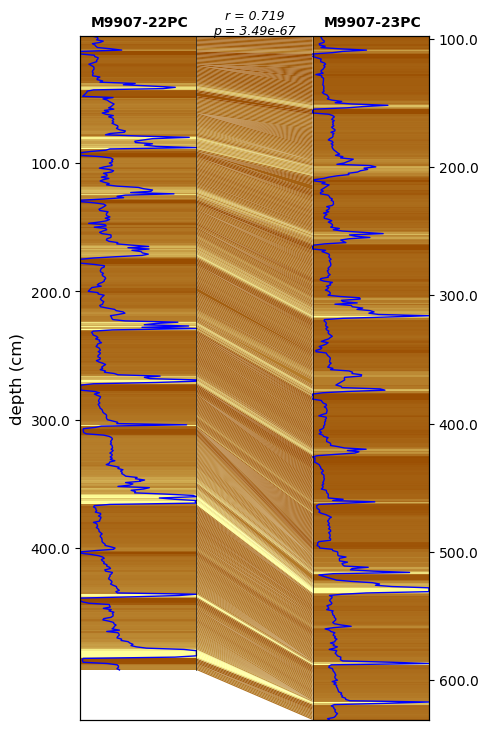

In [28]:
# results depend a lot on how exactly the normalization is done!
slope, intercept, r_value, p_value, slope_std_error = correlate_and_plot_logs(normalize_log(ptms_22, lo_pct=2.5, up_pct=97.5), 
                                                                              normalize_log(ptms_23, lo_pct=2.5, up_pct=97.5)[95:620], 
                                                                              ptmsdepth_22, 
                                                                              ptmsdepth_23[95:620], 
                                                                              exponent = .3,
                                                                              filename1=corename_22, 
                                                                              filename2=corename_23)

<hr>

## Randomization

### Create 'database' of individual turbidites
Manually select the tops of turbidites by clicking on the interactive image.
Installation of matplotlib and ipympl are required

In [29]:
def onclick_boundary(event, xs, lines, ax, toolbar):
    """
    Handle mouse click events: left-click to add x value and vertical line
    Only active when toolbar is not being used
    """
    if event.inaxes == ax and event.name == 'button_press_event':
        # Check if any toolbar buttons are active
        if toolbar.mode == '' and not selection_complete[0]:  # No buttons pressed and selection not complete
            if event.button == 1:  # Left mouse button
                x1 = event.xdata
                xs.append(x1)
                # Add a vertical red dashed line at the clicked x position
                line = ax.axvline(x=x1, color='r', linestyle='--')
                lines.append(line)
                ax.figure.canvas.draw_idle()
                print(f'Added x={x1:.2f}')

def onkey_boundary(event, xs, lines, ax, cid, toolbar):
    """
    Handle keyboard events: delete to remove last point, enter to finish
    """
    if event.key == 'delete' or event.key == 'backspace':
        if xs and not selection_complete[0]:
            removed_x = xs.pop()
            removed_line = lines.pop()
            removed_line.remove()  # Remove the line from the plot
            ax.figure.canvas.draw_idle()
            print(f'Removed x={removed_x:.2f}')
        else:
            print('No points to remove.')
    elif event.key == 'enter':
        # Disconnect the event handlers
        fig.canvas.mpl_disconnect(cid[0])
        fig.canvas.mpl_disconnect(cid[1])
        selection_complete[0] = True
        ax.set_title("Selection Completed")
        print('Finished selecting points. Selection is now locked.')

def create_interactive_figure(md, log, miny, maxy):
    """
    Create an interactive plot.

    :param md: List or array for x-axis data
    :param log: List or array for y-axis data
    :param miny: Minimum y-axis limit
    :param maxy: Maximum y-axis limit
    :return: Matplotlib figure and axes objects
    """
    fig, ax = plt.subplots(figsize=(18, 3))  # Keep the original figure size
    ax.plot(md, log, linestyle='-')  # Removed marker='o' to eliminate dots
    ax.set_ylim(miny, maxy)
    ax.set_xlim(md[0], md[-1])
    ax.set_xlabel('depth(cm)')
    ax.set_ylabel('Log Value')
    ax.set_title('Interactive Selection: `Left-Click` to Add, `Delete/Backspace` to Remove, `Enter/Return` to Finish')
    return fig, ax



Instructions:
 - Left-click on the plot to select and save an x-value.
 - Press Delete/Backspace to undo the last selection.
 - Press Enter when finished selecting points.
 - Pan and Zoom tools will temporarily disable point selection.


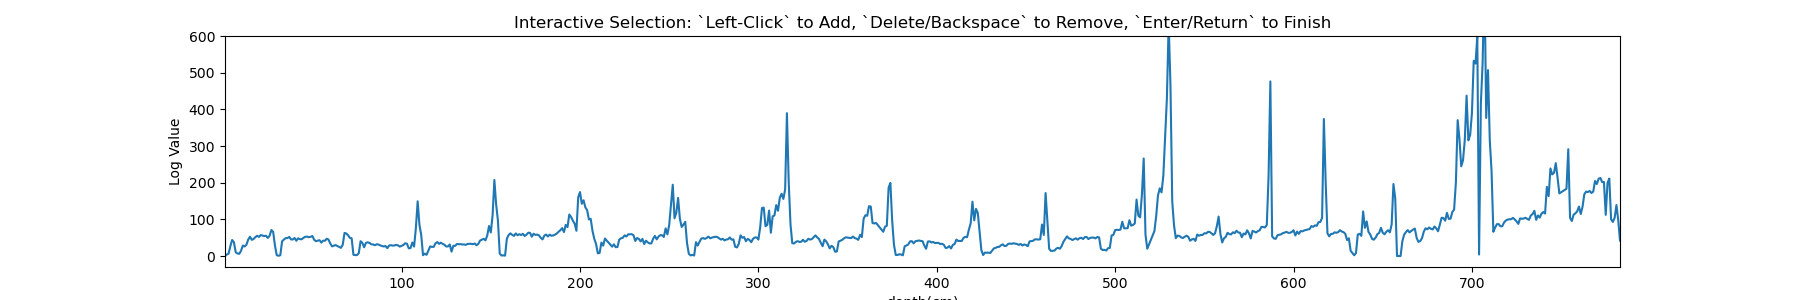

In [30]:
# Enable the interactive widget backend
%matplotlib widget

# Code for creating an interactive plot to extract x values
fig, ax = create_interactive_figure(ptmsdepth_23, ptms_23, -30, 600)
xs = []         # List to store clicked x-values
lines = []      # List to store vertical line objects
selection_complete = [False]  # Using list to allow modification in nested functions

# Get the toolbar instance
toolbar = fig.canvas.toolbar

# Connect both click and keyboard events to their handlers
cid = [
    fig.canvas.mpl_connect('button_press_event', lambda event: onclick_boundary(event, xs, lines, ax, toolbar)),
    fig.canvas.mpl_connect('key_press_event', lambda event: onkey_boundary(event, xs, lines, ax, cid, toolbar))
]

# Display instructions
print("Instructions:")
print(" - Left-click on the plot to select and save an x-value.")
print(" - Press Delete/Backspace to undo the last selection.")
print(" - Press Enter when finished selecting points.")
print(" - Pan and Zoom tools will temporarily disable point selection.")

In [31]:
# Save the array of all clicked x values as a variable
xs.sort()  # Sort in ascending order
print(xs)

[]


In [32]:
# tops_22 = [0.0, 13.040143369175638, 43.848745519713276, 91.6551971326165, 129.19211469534054, 
#            175.5820788530466, 231.53333333333336, 273.673835125448, 307.31541218637994, 
#            367.5161290322581, 403.28243727598567, 439.4028673835126, 486.50107526881726]

tops_23 = [7.726881720430114, 30.149820788530477, 73.87455197132617, 111.99354838709677, 155.15770609318992, 209.5333333333333, 261.66666666666663, 319.405734767025, 344.0709677419354, 377.70537634408595, 425.9146953405017, 464.59426523297486, 493.18351254480285, 518.9698924731182, 534.6659498207885, 559.8917562724014, 589.6021505376343, 620.4336917562723, 645.0989247311827, 658.552688172043, 712.9283154121863, 756.0924731182795, 778.5154121863799]

In [33]:
turb_logs = []
depth_logs = []
log_number = []

def add_turbidites_to_database(turb_logs, depth_logs, log_number, log, md, tops):
    count = 0
    for i in range(len(tops) - 1):
        turb_logs.append(log[(md < tops[i+1]) & (md >= tops[i])])
        depth_log = md[(md < tops[i+1]) & (md >= tops[i])]
        depth_log = depth_log - min(depth_log)
        depth_logs.append(depth_log)
        log_number.append(count)
        count += 1

# add_turbidites_to_database(turb_logs, depth_logs, log_number, ptms_22, ptmsdepth_22, tops_22)
add_turbidites_to_database(turb_logs, depth_logs, log_number, ptms_23, ptmsdepth_23, tops_23)

In [34]:
len(depth_logs)

22

In [41]:
def plot_logs_w_turb_boundaries(md, log, tops):
    fig = plt.figure(figsize=(15, 4))
    plt.plot(md, normalize_log(log), '-')
    plt.ylim(0, 1)
    count = 0
    for i in range(len(tops)):
        plt.plot([tops[i], tops[i]], [0, 1], 'r' )
        plt.text(tops[i], 0.2, str(count))
        count += 1
    return fig

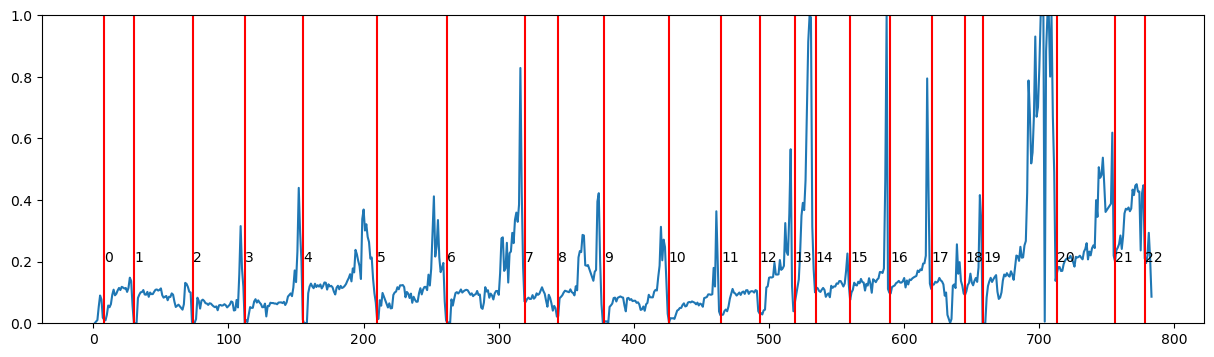

In [42]:
# %matplotlib inline

# check how the tops look like when plotted on the log
fig = plot_logs_w_turb_boundaries(ptmsdepth_23, ptms_23, tops_23)

# Correlation Functions

This cell defines two key correlation functions:

1. `correlate_log_w_synthetic_logs()`: Correlates a real log with synthetic logs generated from a database of turbidites. For each iteration:
   - Takes a real log and normalizes it
   - Creates a synthetic log by randomly sampling turbidites from the database
   - Correlates the two logs and calculates the r-value
   - If r-value > 0.85, plots the correlation
   - Returns array of r-values across all iterations

2. `correlate_synth_log_w_synth_logs()`: Correlates pairs of synthetic logs. For each iteration:
   - Creates two synthetic logs by randomly sampling different turbidites
   - Ensures no turbidites are reused between the logs
   - Correlates the logs and calculates r-value 
   - If r-value > 0.85, plots the correlation
   - Returns array of r-values across all iterations

Both functions use dynamic time warping for correlation and help assess the similarity between turbidite sequences.


In [37]:
from tqdm import trange

def correlate_log_w_synthetic_logs(md, log, thickness, nit, exponent, turb_logs, depth_logs):
    r_values = []
    for i in trange(nit):
        exponent = exponent
        log1 = normalize_log(log)
        d1 = md
        fake_log = np.array([])
        md_log = np.array([])
        max_depth = 0
        while max_depth <= thickness:
            ind = random.choices(np.arange(len(turb_logs)), k=1)[0]
            fake_log = np.hstack((fake_log, turb_logs[ind].flatten()))
            if len(md_log) == 0:
                md_log = np.hstack((md_log, 1 + depth_logs[ind]))
            else:
                md_log = np.hstack((md_log, 1 + md_log[-1] + depth_logs[ind]))
            max_depth = md_log[-1]
        log2 = normalize_log(fake_log)
        d2 = md_log
        p, q, D = correlate_logs(log1, log2, exponent)
        vsh_means1 = log1[p]
        vsh_means1[np.where(np.diff(p)==0)[0] + 1] = np.nan
        vsh_means2 = log2[q]
        vsh_means2[np.where(np.diff(q)==0)[0] + 1] = np.nan
        slope, intercept, r_value, p_value, slope_std_rror = stats.linregress(vsh_means1[(np.isnan(vsh_means1)==0) & (np.isnan(vsh_means2)==0)], 
                                                                          vsh_means2[(np.isnan(vsh_means1)==0) & (np.isnan(vsh_means2)==0)])
        r_values.append(r_value)
        step = 1
        if r_value > 0.85:
            plot_correlation(log1, log2, d1, d2, p, q, step)
            print(r_value)
    return r_values

def correlate_synth_log_w_synth_logs(thickness, nit, exponent, turb_logs, depth_logs):
    """
    correlate synthetic log pairs
    """
    r_values = []
    for i in trange(nit):
        # create first log:
        fake_log = np.array([])
        md_log = np.array([])
        max_depth = 0
        inds = []
        while max_depth <= thickness:
            ind = random.choices(np.arange(len(turb_logs)), k=1)[0]
            inds.append(ind)
            fake_log = np.hstack((fake_log, turb_logs[ind].flatten()))
            if len(md_log) == 0:
                md_log = np.hstack((md_log, 1 + depth_logs[ind]))
            else:
                md_log = np.hstack((md_log, 1 + md_log[-1] + depth_logs[ind]))
            max_depth = md_log[-1]
        log1 = normalize_log(fake_log)
        d1 = md_log.copy()
        
        # create second log:
        fake_log = np.array([])
        md_log = np.array([])
        max_depth = 0
        while max_depth <= thickness:
            ind = random.choices(np.arange(len(turb_logs)), k=1)[0]
            if ind not in inds: # make sure that we are not using any of the turbidites in the first log
                fake_log = np.hstack((fake_log, turb_logs[ind].flatten()))
                if len(md_log) == 0:
                    md_log = np.hstack((md_log, 1 + depth_logs[ind]))
                else:
                    md_log = np.hstack((md_log, 1 + md_log[-1] + depth_logs[ind]))
                max_depth = md_log[-1]
        log2 = normalize_log(fake_log)
        d2 = md_log.copy()
        
        p, q, D = correlate_logs(log1, log2, exponent)
        vsh_means1 = log1[p]
        vsh_means1[np.where(np.diff(p)==0)[0] + 1] = np.nan
        vsh_means2 = log2[q]
        vsh_means2[np.where(np.diff(q)==0)[0] + 1] = np.nan
        slope, intercept, r_value, p_value, slope_std_rror = \
            stats.linregress(vsh_means1[(np.isnan(vsh_means1)==0) \
            & (np.isnan(vsh_means2)==0)], vsh_means2[(np.isnan(vsh_means1)==0) & (np.isnan(vsh_means2)==0)])
        r_values.append(r_value)
        step = 1
        if r_value > 0.85: # plot correlation if r value is very large
            plot_correlation(log1, log2, d1, d2, p, q, step)
            print(r_value)
    return r_values


# 12-11 correlation

#### High-Resolution Magnetic Susceptibility

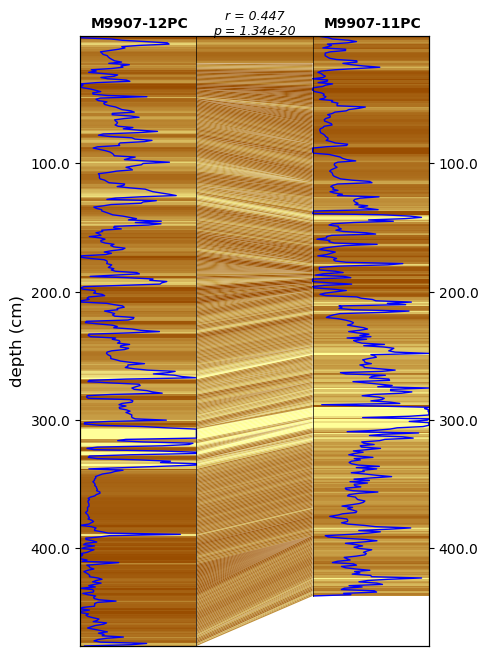

In [38]:
slope, intercept, r_value, p_value, slope_std_error = correlate_and_plot_logs(normalize_log(ptms_12, lo_pct=2.5, up_pct=97.5), 
                                                                              normalize_log(ptms_11, lo_pct=2.5, up_pct=97.5), 
                                                                              ptmsdepth_12, 
                                                                              ptmsdepth_11, 
                                                                              exponent = 0.3,
                                                                              filename1=corename_12,
                                                                              filename2=corename_11)

## 12-11 correlation - alternative
#### This is the Goldfinger et al. correlation (between T6 and T20):

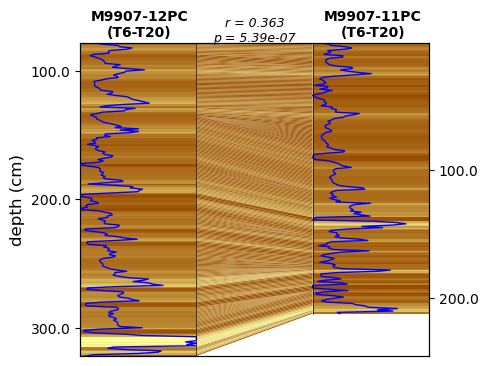

In [39]:
slope, intercept, r_value, p_value, slope_std_error = correlate_and_plot_logs(normalize_log(ptms_12, lower_percentile=2.5, upper_percentile=97.5)[77:321], 
                                                                              normalize_log(ptms_11, lower_percentile=2.5, upper_percentile=97.5)[:211], 
                                                                              ptmsdepth_12[77:321], 
                                                                              ptmsdepth_11[:211], 
                                                                              exponent = 0.3,
                                                                              filename1=(corename_12 + '\n(T6-T20)'),
                                                                              filename2=corename_11 + '\n(T6-T20)')

#### Correlation of a restricted interval (with better looking correlation than the previous two):

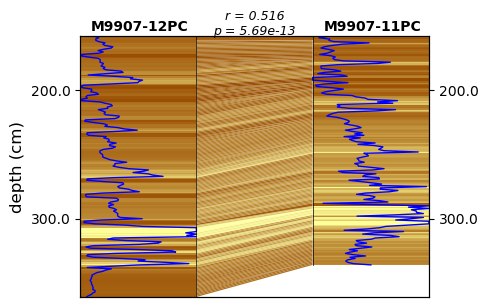

In [40]:
slope, intercept, r_value, p_value, slope_std_error = correlate_and_plot_logs(normalize_log(ptms_12, lower_percentile=2.5, upper_percentile=97.5)[157:359], 
                                            normalize_log(ptms_11, lower_percentile=2.5, upper_percentile=97.5)[156:334], 
                                            ptmsdepth_12[157:359], 
                                            ptmsdepth_11[156:334], 
                                            exponent = 0.3,
                                            filename1=corename_12,
                                            filename2=corename_11)